In [1]:
from sklearn.metrics import accuracy_score,mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.pipeline import make_pipeline,make_union
from sklearn.preprocessing import MinMaxScaler, Imputer,PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV,KFold,train_test_split
import warnings
from sklearn.feature_selection import SelectPercentile,SelectKBest, VarianceThreshold
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#Need to run all Data Prep Notebook cells
%store -r data

In [4]:
data.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,160,43,23,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,False,0,22,0.0,0.0,1533.95
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,145,20,51,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,False,15,50,100.0,2421.0,30000.00
1000004038,Where is Hank?,145,20,51,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,False,3,50,220.0,220.0,45000.00
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,142,35,51,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,False,1,50,1.0,1.0,5000.00
1000011046,Community Film Project: The Art of Neighborhoo...,107,20,51,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,False,14,50,1283.0,1283.0,19500.00


## Make a new feature

In [97]:
num_cam = data['launched'].groupby([data['launched'].dt.year.rename('year'), data['launched'].dt.month.rename('month')]).agg({'count'})

In [98]:
data["month"] = data["launched"].dt.month
data["month_deadline"] = data["deadline"].dt.month
data["launch_day_of_week"] = data["launched"].dt.dayofweek
data["duration"] = ((data["deadline"]  - data['launched'])/ np.timedelta64(1, 'D')).astype(int)
data["year"] = data["launched"].dt.year

In [99]:
data = pd.merge(data, num_cam, on=["month","year"])

In [100]:
def state_to_num(x):
    if x < 0.5: return 0
    elif 0.5<= x < 1 : return 1
    elif 1<= x <= 1.5: return 2
    else: return 3
data["state_num"] = [state_to_num(x)for x in  (data.usd_pledged_real/data.usd_goal_real)]

In [101]:
data.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,...,duration,month_launched,month_deadline,launch_day_of_week,state_num,month,year,count_x,count_y,count
0,The Songs of Adelaide & Abullah,160,43,23,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,False,0,...,58,8,10,1,0,8,2015,5723,5723,5723
1,Legacy of Svarog | a Unique 3D Action RPG and ...,200,24,51,2015-10-30,50000.0,2015-08-31 06:33:31,1410.0,False,38,...,59,8,10,0,0,8,2015,5723,5723,5723
2,Gantish - Online Reward Chart Creator for Parents,183,48,17,2015-09-16,4000.0,2015-08-17 15:37:03,282.0,False,12,...,29,8,9,0,0,8,2015,5723,5723,5723
3,Fomatek: Foam Laptop Desks & Music Stands Elev...,165,15,51,2015-09-26,10000.0,2015-08-27 22:02:59,805.0,False,10,...,29,8,9,3,0,8,2015,5723,5723,5723
4,Wood Floor Fundraiser,88,14,51,2015-08-16,1200.0,2015-08-11 17:13:30,1205.0,True,21,...,4,8,8,1,2,8,2015,5723,5723,5723


In [102]:
feature = data[['category', 'main_category', 'currency', 'goal','duration', 'country', 'month', 'month_deadline', 'launch_day_of_week', 'count_x']]
outcome = data[['state']]
feature_name = data[["name"]]

In [103]:
feature.head()

,category,main_category,currency,goal,duration,country,month,month_deadline,launch_day_of_week,count_x
0,160,43,23,1000.0,58,22,8,10,1,5723
1,200,24,51,50000.0,59,50,8,10,0,5723
2,183,48,17,4000.0,29,27,8,9,0,5723
3,165,15,51,10000.0,29,50,8,9,3,5723
4,88,14,51,1200.0,4,50,8,8,1,5723


## Split test and train data set

In [104]:
train_features_small, validation_features, train_outcome_small, validation_outcome = train_test_split(
    feature,
    outcome,
    test_size = 0.3
)
train_name_small, validation_name_features, train_outcome_small_name, validation_name_outcome = train_test_split(
    feature_name,
    outcome,
    test_size = 0.3
)

# Predict the State by Its Name

In [69]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [35]:
text_clf = make_pipeline(
                    CountVectorizer(),
                    TfidfTransformer(),
                    SGDClassifier(penalty='l2', tol=None,max_iter=10)
)

param = {'countvectorizer__ngram_range': [(1, 1), (1, 2)],
    'tfidftransformer__use_idf': (True, False),
    "sgdclassifier__alpha":[1e-3,0.001],
}

grid_search_text = GridSearchCV(text_clf, n_jobs=-1,cv=5,iid=False,param_grid=param)
grid_search_text.fit(train_name_small.name,train_outcome_small_name)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'countvectorizer__ngram_range': [(1, 1), (1, 2)], 'tfidftransformer__use_idf': (True, False), 'sgdclassifier__alpha': [0.001, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [36]:
print(classification_report(validation_outcome, grid_search_text.best_estimator_.predict(validation_name_features.name)))

             precision    recall  f1-score   support

      False       0.64      0.99      0.78     72446
       True       0.35      0.01      0.02     40313

avg / total       0.54      0.64      0.51    112759



In [37]:
text_clf = make_pipeline(
                    CountVectorizer(),
                    TfidfTransformer(),
                    SelectKBest(k=10),
                    MLPClassifier(hidden_layer_sizes=(500,10,2),  
                                  activation='relu', 
                                   batch_size='auto', 
                                  learning_rate_init=0.01, power_t=0.5, 
                                  max_iter=1000, shuffle=True,
                                  tol=0.0001, verbose=False, warm_start=False,
                                  momentum=0.9, nesterovs_momentum=True,
                                    early_stopping=False, validation_fraction=0.1,
                                  beta_1=0.9,beta_2=0.999, epsilon=1e-08)
                                )


param = {'countvectorizer__ngram_range': [(1, 1), (1, 2)],
    'tfidftransformer__use_idf': (True, False)
}

grid_search_text = GridSearchCV(text_clf, n_jobs=-1,cv=5,iid=False,param_grid=param)
grid_search_text.fit(train_name_small.name,train_outcome_small_name)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))]),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'countvectorizer__ngram_range': [(1, 1), (1, 2)], 'tfidftransformer__use_idf': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [38]:
print(classification_report(validation_outcome, grid_search_text.predict(validation_name_features.name)))


             precision    recall  f1-score   support

      False       0.64      1.00      0.78     72446
       True       0.00      0.00      0.00     40313

avg / total       0.41      0.64      0.50    112759



In [39]:
grid_search_text.best_score_

0.6514255352648519

In [40]:
grid_search_text.score(validation_name_features.name,validation_name_outcome)

0.6434874378098422

In [41]:
name_proba = grid_search_text.predict_log_proba(validation_features)

# Predict the State by other value

In [105]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_features="auto",max_depth=4, min_samples_split=2)
pipe = make_pipeline(VarianceThreshold(.1),
                     SelectKBest(k=10),
                     rfc
                     )

params ={'randomforestclassifier__n_estimators':[40],
        }

grid_search_rf = GridSearchCV(pipe, params,
                               cv = KFold(n_splits=10, shuffle=True),n_jobs = -1)

In [106]:
grid_search_rf.fit(train_features_small, train_outcome_small)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('variancethreshold', VarianceThreshold(threshold=0.1)), ('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x0000017EDF1068C8>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='aut...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'randomforestclassifier__n_estimators': [40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [107]:
grid_search_rf.best_params_

{'randomforestclassifier__n_estimators': 40}

In [108]:
print(classification_report(validation_outcome, grid_search_rf.best_estimator_.predict(validation_features)))

             precision    recall  f1-score   support

      False       0.67      0.96      0.79     72571
       True       0.64      0.14      0.22     40188

avg / total       0.66      0.66      0.59    112759



In [109]:
grid_search_rf.score(validation_features,validation_outcome)

0.6645323211450971

In [119]:
#validation_features['preds'] = grid_search_rf.predict(validation_features)
#validation_features['actual'] = validation_outcome['state']


true_df = validation_features.loc[validation_features['actual'] == validation_features['preds']][['actual', 'preds']]
false_df = validation_features.loc[validation_features['actual'] != validation_features['preds']][['actual', 'preds']]

true_positives = len(true_df[true_df['preds']==1])
false_negatives = len(false_df[false_df['preds']==0])
true_negatives = len(true_df[true_df['preds']==0])
false_positives = len(false_df[false_df['preds']==1])

sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
type_1_error = 1 - specificity
type_2_error = 1 - sensitivity


print(sensitivity)
print(f'Specificity: {specificity}')
print(type_1_error)
print(type_2_error)

0.13583656812978998
Specificity: 0.9573107715203043
0.042689228479695696
0.86416343187021


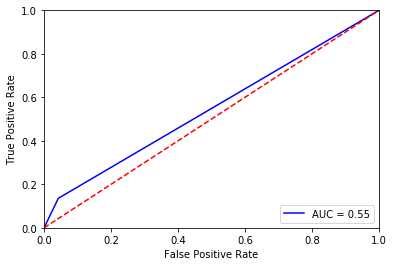

In [123]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_true=validation_features.actual, y_score=validation_features.preds)
roc_auc = metrics.auc(fpr, tpr)

# Draw your ROC curve
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [126]:
metrics.roc_auc_score(y_true=validation_features.actual, y_score=validation_features.preds)

0.5465736698250471

# Combine two Prediction Together

In [42]:
total_proba = name_proba * rf_proba

ValueError: operands could not be broadcast together with shapes (9,2) (112759,2) 

In [108]:
total_proba

array([[0.27718412, 0.79689983],
       [0.52655006, 0.43774873],
       [0.29568657, 0.75431854],
       ...,
       [0.10719979, 1.48391614],
       [0.657058  , 0.30049206],
       [0.4828025 , 0.47806432]])

In [112]:
total_pred = [(x[0] >= x[1])for x in total_proba]

In [113]:
validation_outcome["pred"] = total_pred

In [114]:
len(validation_outcome[validation_outcome["pred"]==validation_outcome["state"]])/len(validation_outcome)

0.643489018663616

### Neural Network test

In [118]:
from sklearn.neural_network import MLPClassifier

    
pipe = make_pipeline(VarianceThreshold(0.1),
                    SelectKBest(k = 9),
                     MLPClassifier(hidden_layer_sizes=(13,5,),  
                                  activation='relu', 
                                   batch_size='auto', 
                                  learning_rate_init=0.01, power_t=0.5, 
                                  max_iter=1000, shuffle=True,
                                  tol=0.0001, verbose=False, warm_start=False,
                                  momentum=0.9, nesterovs_momentum=True,
                                    early_stopping=False, validation_fraction=0.1,
                                  beta_1=0.9,beta_2=0.999, epsilon=1e-08)
                                )
params ={'mlpclassifier__alpha':[0.0001,0.001,0.01],
         'mlpclassifier__solver':['lbfgs',  'adam']
        }

grid_search_nn = GridSearchCV(pipe, param_grid = params,cv = KFold(n_splits=5, shuffle=True),n_jobs=-1)

In [119]:
train_outcome_small.state = train_outcome_small.state.astype(int)

In [120]:
grid_search_nn.fit(train_features_small,train_outcome_small)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('variancethreshold', VarianceThreshold(threshold=0.1)), ('selectkbest', SelectKBest(k=9, score_func=<function f_classif at 0x000001A742D0AA60>)), ('mlpclassifier', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'mlpclassifier__alpha': [0.0001, 0.001, 0.01], 'mlpclassifier__solver': ['lbfgs', 'adam']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [121]:
grid_search_nn.score(validation_features,validation_outcome)

0.6434342269796646